In [1]:
from loss import YoloLoss
import torch
from dataset import VOCDataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import Yolov1
from utils import calculate_iou, mean_average_precision, non_max_suppression, cellboxes_to_boxes, plot_image
from torchvision import transforms
import torch.optim as optim
import torch_directml
import numpy as np
from PIL import Image

In [2]:
seed = 123
torch.manual_seed(seed)

In [3]:
my_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor()
])

IMAGE_DIR = "../VOC/images"
LABEL_DIR = "../VOC/labels"
BATCH_SIZE = 16

test_data = VOCDataset(csv_file="../VOC/test.csv",
                       img_dir=IMAGE_DIR, label_dir=LABEL_DIR, transform=my_transform)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
DEVICE = torch_directml.device()
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)
model.load_state_dict(torch.load("./model_weights.pth", weights_only=True, map_location="cpu"))
model = model.to(DEVICE)

In [5]:
outs = []
imgs_path = []
model.eval()
with torch.no_grad():
    for img, label, img_path in tqdm(test_loader):
        img, label = img.to(DEVICE), label.to(DEVICE), 
        out = model(img)
        outs.extend(out.reshape(len(img), 7, 7, -1).cpu())
        imgs_path.extend(img_path)

100%|██████████| 310/310 [01:02<00:00,  4.99it/s]


In [6]:
bboxes = cellboxes_to_boxes(outs)

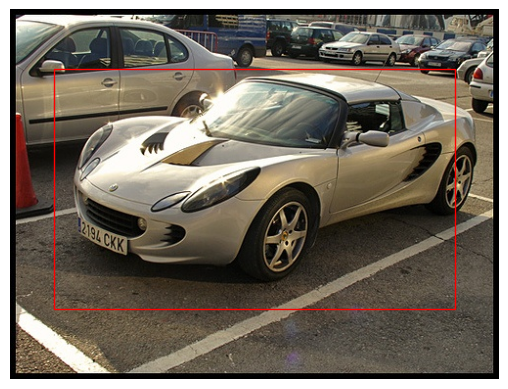

In [71]:
idx = np.random.randint(len(imgs_path))
img = Image.open(imgs_path[idx])
plot_image(np.array(img), bboxes[idx])